In [25]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/marketing_campaign.csv', sep='\t')

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Select only numeric columns for filling missing values
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

In [36]:
# Convert 'Dt_Customer' to datetime
from sklearn.preprocessing import LabelEncoder
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# Encode categorical variables
labelencoder = LabelEncoder()
df['Education'] = labelencoder.fit_transform(df['Education'])
df['Marital_Status'] = labelencoder.fit_transform(df['Marital_Status'])


In [27]:
# Create a new feature 'Age'
df['Age'] = 2024 - df['Year_Birth']

# Select relevant features for clustering
features = df[['Age', 'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]


In [28]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features to a DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)


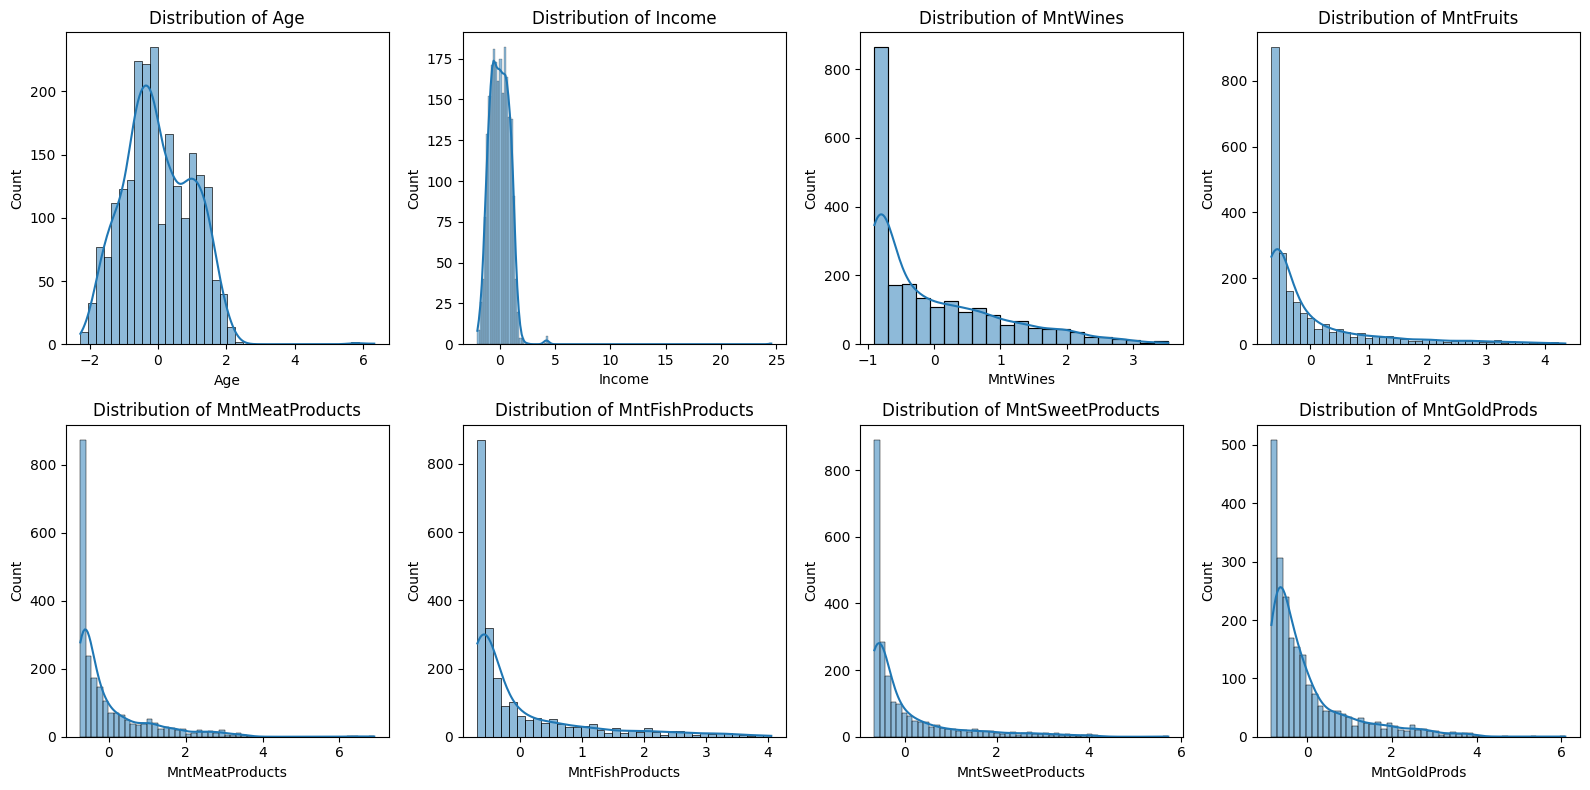

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distributions of features
plt.figure(figsize=(16, 8))
for i, col in enumerate(scaled_features_df.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(scaled_features_df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

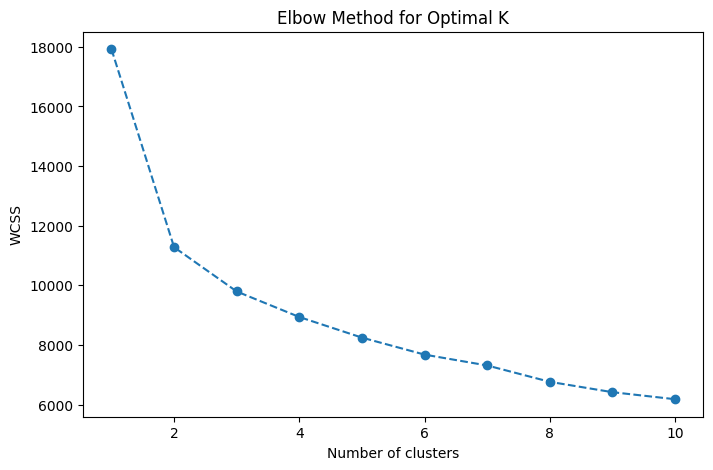

Silhouette Score for k=2: 0.4205728824655524
Silhouette Score for k=3: 0.31829430650617857
Silhouette Score for k=4: 0.2316630666075229
Silhouette Score for k=5: 0.24654271342084288
Silhouette Score for k=6: 0.24757168448338263
Silhouette Score for k=7: 0.24669950933467127
Silhouette Score for k=8: 0.24791070380091884
Silhouette Score for k=9: 0.25180021405114134
Silhouette Score for k=10: 0.25744463888298075


In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score for K-means
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    print(f'Silhouette Score for k={k}: {score}')

# Apply K-means with the optimal number of clusters
optimal_clusters = 2  # Adjust based on the elbow method and silhouette score
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, n_init=10)
kmeans.fit(scaled_features)
df['KMeans_Cluster'] = kmeans.labels_


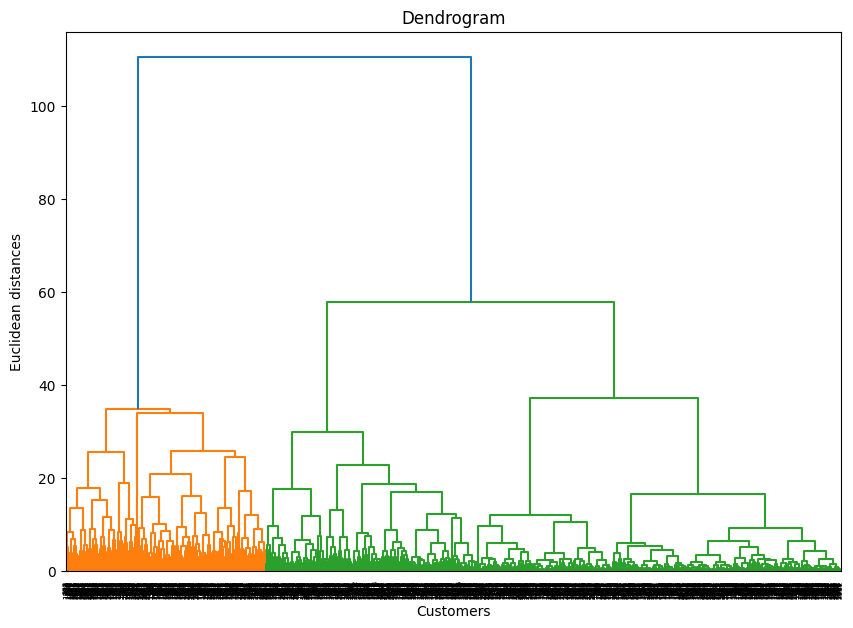

In [31]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Create dendrogram to find the optimal number of clusters
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(scaled_features, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

# Apply Agglomerative Clustering with the optimal number of clusters
hc = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
df['HC_Cluster'] = hc.fit_predict(scaled_features)


In [32]:
# Analyze Cluster Characteristics
kmeans_clusters = df.groupby('KMeans_Cluster').mean()
hc_clusters = df.groupby('HC_Cluster').mean()

print("K-means Cluster Characteristics:\n", kmeans_clusters)
print("Hierarchical Clustering Cluster Characteristics:\n", hc_clusters)


K-means Cluster Characteristics:
                          ID   Year_Birth  Education  Marital_Status  \
KMeans_Cluster                                                        
0               5607.348444  1969.506766   2.405277        3.721922   
1               5562.699475  1967.446194   2.371391        3.745407   

                      Income   Kidhome  Teenhome  \
KMeans_Cluster                                     
0               41165.265238  0.631258  0.587280   
1               73742.232298  0.081365  0.349081   

                                 Dt_Customer    Recency    MntWines  ...  \
KMeans_Cluster                                                       ...   
0              2013-07-23 09:15:20.703653632  48.811908  147.170501  ...   
1              2013-06-15 06:21:43.937007872  49.686352  608.002625  ...   

                AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
KMeans_Cluster                                                           
0                  

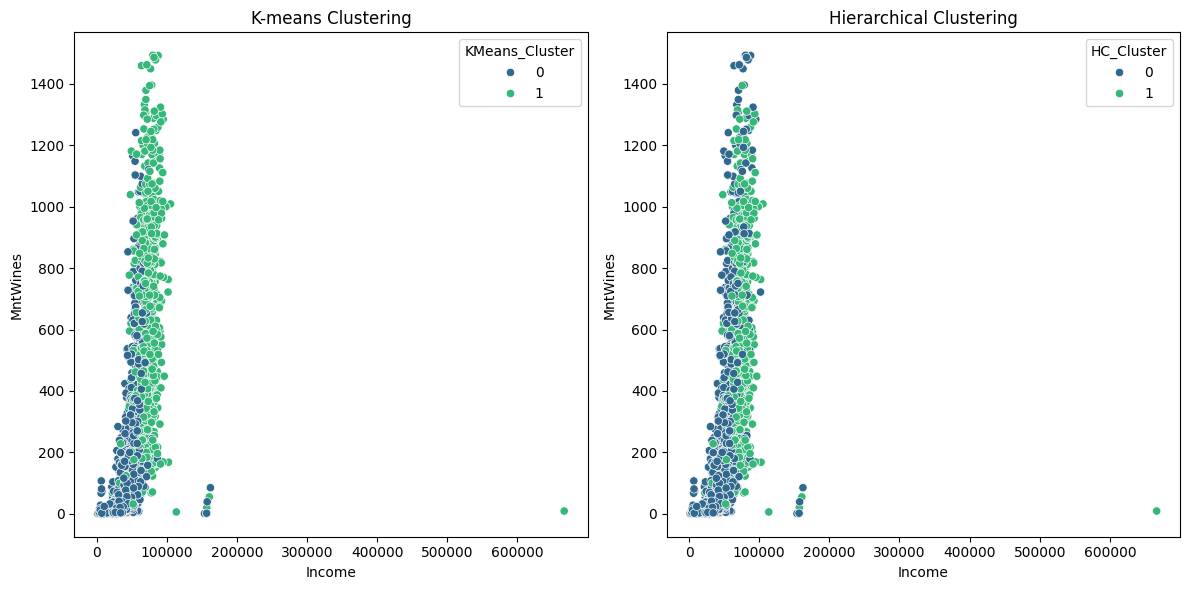

In [33]:
# Visualize Clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Income', y='MntWines', hue='KMeans_Cluster', data=df, palette='viridis')
plt.title('K-means Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Income', y='MntWines', hue='HC_Cluster', data=df, palette='viridis')
plt.title('Hierarchical Clustering')

plt.tight_layout()
plt.show()


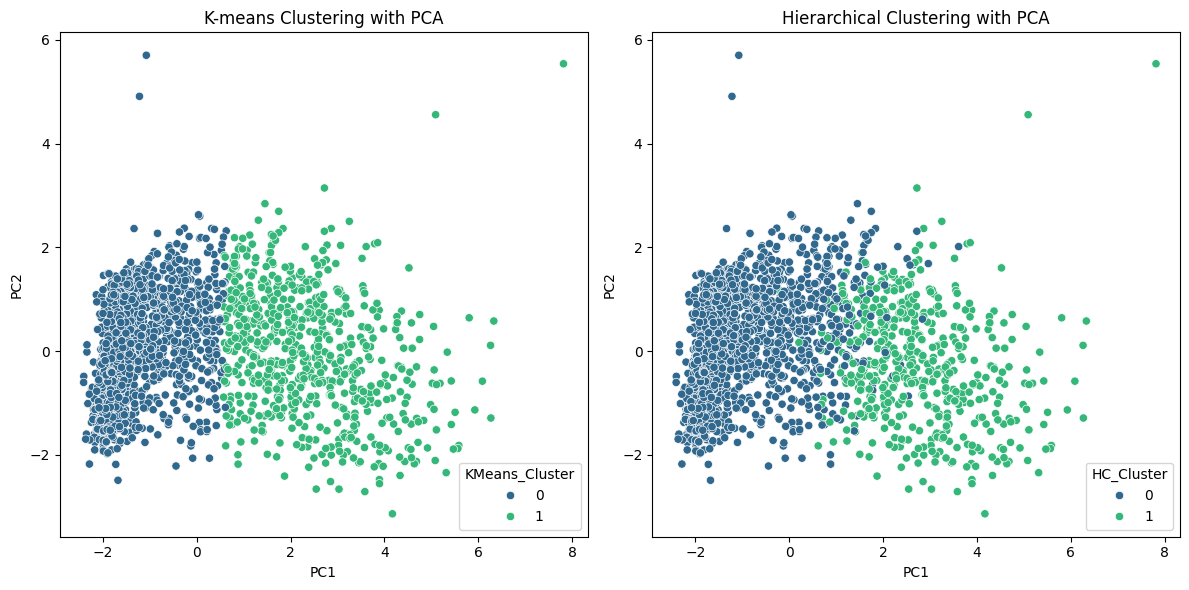

In [34]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame for principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = df['KMeans_Cluster']
pca_df['HC_Cluster'] = df['HC_Cluster']

# Visualize the PCA result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering with PCA')

plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='HC_Cluster', data=pca_df, palette='viridis')
plt.title('Hierarchical Clustering with PCA')

plt.tight_layout()
plt.show()


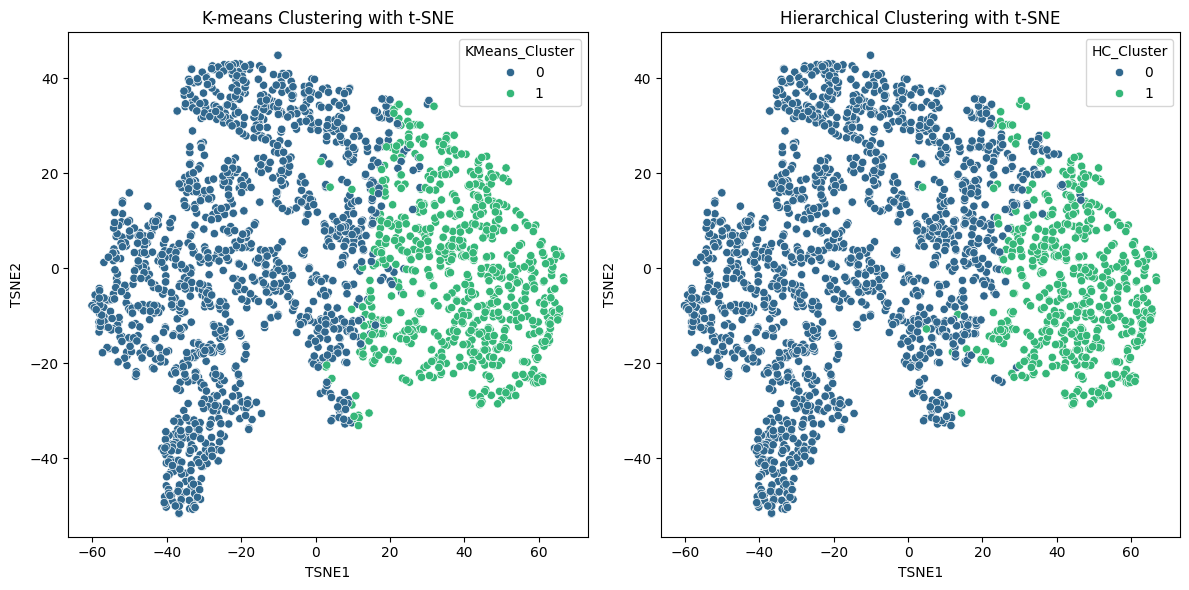

In [35]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)

# Create a DataFrame for t-SNE components
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])
tsne_df['KMeans_Cluster'] = df['KMeans_Cluster']
tsne_df['HC_Cluster'] = df['HC_Cluster']

# Visualize the t-SNE result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='KMeans_Cluster', data=tsne_df, palette='viridis')
plt.title('K-means Clustering with t-SNE')

plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE1', y='TSNE2', hue='HC_Cluster', data=tsne_df, palette='viridis')
plt.title('Hierarchical Clustering with t-SNE')

plt.tight_layout()
plt.show()
